In [1]:
import numpy as np
import pandas as pd

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.tree import DecisionTreeClassifier

In [3]:
df =pd.read_csv('train.csv')

In [5]:
df.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


The following pipleline we are going to create 

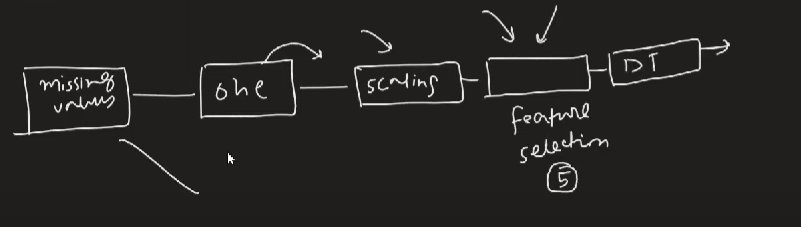

## Let's Plan

In [8]:
df.drop(columns = ['PassengerId','Name','Ticket','Cabin'], inplace = True)

In [9]:
df.head(2)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C


In [10]:
# Train test split:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['Survived']), df['Survived'], test_size=0.2, random_state=42)

In [13]:
X_train.head(2)


,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
331,1,male,45.5,0,0,28.5,S
733,2,male,23.0,0,0,13.0,S


## 1. First part of pipeline:
##### Passing list of tuples to the columnsTransformer

In [15]:
# imputation transformer
trf1 = ColumnTransformer([('impute_age', SimpleImputer(),[2]),
                          ('impute_embarked',SimpleImputer(strategy='most_frequent'),[6])
                         ], remainder = 'passthrough')

## 2. One Hot Encoding

In [16]:
trf2 = ColumnTransformer([ ('ohe_sex_embarked', OneHotEncoder(sparse=False, handle_unknown='ignore'), [1,6])
                         ], remainder='passthrough')

# 3. Scaling

In [28]:
# since the number of columns will increase to 10 due to encodings.
trf3 = ColumnTransformer([('scale', MinMaxScaler(),slice(0,10))])

# 4. Feature Selection

In [36]:
trf4 = SelectKBest(score_func=chi2,k=5)

# 5. Model training

In [37]:
trf5 = DecisionTreeClassifier()

## Create pipeline

In [38]:
# list of tuples.
pipe = Pipeline([
    ('trf1',trf1),('trf2',trf2),('trf3',trf3),('trf4',trf4),('trf5',trf5)
])

In [39]:
# train
pipe.fit(X_train, y_train)

C:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Pipeline(steps=[('trf1',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('impute_age', SimpleImputer(),
                                                  [2]),
                                                 ('impute_embarked',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  [6])])),
                ('trf2',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe_sex_embarked',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  [1, 6])])),
                ('trf3',
                 ColumnTransformer(transformers=[('scale', MinMaxScaler(),
                                                  slice(0, 10, None))])),
                ('trf4',
                 SelectKBest(k=5,
                             score_func=<function chi2 at 0x00000263AD9B5800>)),
                ('trf5', DecisionTreeClassifier())])

Postmortem of the pipeline

In [55]:
pipe.named_steps['trf1'].transformers_

[('impute_age', SimpleImputer(), [2]),
 ('impute_embarked', SimpleImputer(strategy='most_frequent'), [6]),
 ('remainder', 'passthrough', [0, 1, 3, 4, 5])]

In [64]:
pipe.named_steps['trf1'].transformers_[0][1].statistics_

array([29.49884615])

In [66]:
# Predict
y_pred = pipe.predict(X_test)

In [84]:
type(y_pred)

numpy.ndarray

In [67]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,y_pred)

0.6256983240223464

# Cross Validation using pipelin

In [86]:
import warnings
warnings.filterwarnings('ignore')

In [88]:
# using cross_val_score
from sklearn.model_selection import cross_val_score
p = cross_val_score(pipe, X_train,y_train, cv=5)

In [96]:
p

array([0.6013986 , 0.62237762, 0.68309859, 0.65492958, 0.63380282])

# Hyper Parameter Tuning

In [98]:
#  GridSearch Using Pipeline
params = {
    'trf5__max_depth': [1,2,3,4,5,None] 
}

In [99]:
from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(pipe, params, cv = 5, scoring='accuracy')
grid.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('trf1',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('impute_age',
                                                                         SimpleImputer(),
                                                                         [2]),
                                                                        ('impute_embarked',
                                                                         SimpleImputer(strategy='most_frequent'),
                                                                         [6])])),
                                       ('trf2',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe_sex_embarked',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse=False),
                                                                         [1,
                                                                          6])])),
                                       ('trf3',
                                        ColumnTransformer(transformers=[('scale',
                                                                         MinMaxScaler(),
                                                                         slice(0, 10, None))])),
                                       ('trf4',
                                        SelectKBest(k=5,
                                                    score_func=<function chi2 at 0x00000263AD9B5800>)),
                                       ('trf5', DecisionTreeClassifier())]),
             param_grid={'trf5__max_depth': [1, 2, 3, 4, 5, None]},
             scoring='accuracy')

In [100]:
grid.best_score_

0.6391214419383433

In [101]:
grid.best_params_

{'trf5__max_depth': 2}

In [102]:
# Exporting the pipeline:
## Now we don't need to send onehot encoder, or other transformers in pkl file separately.

import pickle
pickle.dump(pipe,open('pipe.pkl','wb'))

In [103]:
# In future if any change occur, we only need to go to that specific part of the pipe and 
# do the change and then just  download the pkl file
# we don't need to change the entire coder.

# Predict using pipeline

In [104]:
pipe = pickle.load(open('pipe.pkl','rb'))

In [121]:
# Just random user input
test_input = np.array([2, 'female',32,1,0,22,'C'],dtype=object).reshape(1,7)

In [122]:
pipe.predict(test_input)

array([1], dtype=int64)